In [1]:
import torch
import torch.nn as nn
import os
import sys

sys.path.append('../')

import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat
import pickle
import importlib
import DRLPDE.neuralnets as neuralnets

import matplotlib.pyplot as plt
import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 12

In [2]:
loadmodel = 'Test2'

In [3]:
filename = 'Error_Plot_' + loadmodel
imagesfolder = "images/"

with open('../experiments/' + loadmodel + '_parameters.pickle', 'rb') as f:
    parameters = pickle.load(f)

with open('../experiments/'  + loadmodel + '_losses.pickle', 'rb') as f:
    losses = pickle.load(f)

problem = importlib.import_module(".JCPexample2", package='examples')

input_dim = [problem.x_dim, problem.t_dim, problem.hyper_dim]
output_dim = problem.output_dim

if parameters['neuralnetwork'] == 'FeedForward':
    MyNeuralNetwork = neuralnets.FeedForwardNN
elif parameters['neuralnetwork'] == 'Incompressible':
    MyNeuralNetwork = neuralnets.IncompressibleNN
elif parameters['neuralnetwork'] == 'ResNetIncompressible':
    MyNeuralNetwork = neuralnets.ResNetIncompressible

nn_size = parameters['nn_size']

model = MyNeuralNetwork(input_dim, output_dim, **nn_size)
model.load_state_dict(torch.load("../savedmodels/" + loadmodel + ".pt"))

dim_space = 2
dim_full = dim_space + 1

mu = 1.0
L = 1.0  # Length of box the circle/sphere sits inside + Radius of Disk/Sphere
v0 = 1.0
maxT = 2.0 # Max time

numpts_r = 20
numpts_th =  120
numpts_time = 100
dtime = maxT/numpts_time

r,th,t_var = torch.meshgrid([torch.linspace(0,1, numpts_r), \
                         torch.linspace(0,2*math.pi, numpts_th), \
                         torch.linspace(0,maxT, numpts_time+1)])

x1g = r*torch.cos(th)
x2g = r*torch.sin(th)

xg = torch.stack([x1g.reshape(-1), x2g.reshape(-1), t_var.reshape(-1)], dim=-1)

############# Plot, Video, Error ##################################

r_plot, th_plot = torch.meshgrid([torch.linspace(0,1, numpts_r),
                                 torch.linspace(0,2*math.pi, numpts_th)])

x1plot = r_plot*torch.cos(th_plot)
x2plot = r_plot*torch.sin(th_plot)

xplot = torch.stack( [x1plot.reshape(-1), x2plot.reshape(-1), torch.zeros((numpts_r*numpts_th))], dim=-1).requires_grad_(True)

integral_factor = 2*math.pi*maxT*r_plot/(numpts_r-1)/(numpts_th-1)/(numpts_time-1)
integral_factor = integral_factor.numpy()

x1plot = x1plot.numpy()
x2plot = x2plot.numpy()

c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
levels_stokes = np.linspace(-4.0, 4.0, 100)
error_levels = np.linspace(-0.1, 0.1, 100)

levels_tick = np.linspace(-1.0, 1.0, 3)
error_tick = np.linspace(-0.1, 0.1, 3)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


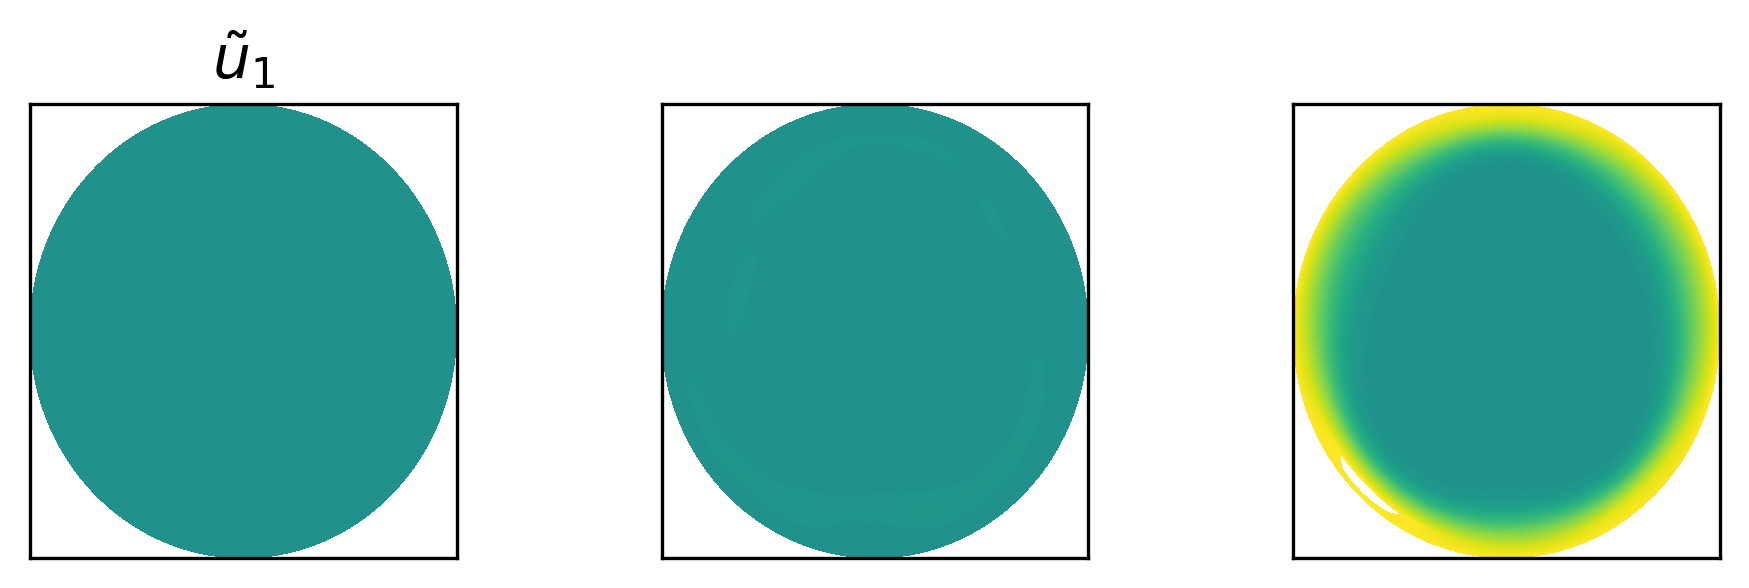

In [5]:
xplot.requires_grad = False
xplot[:,2] = 0.0
xplot.requires_grad = True

Trained_Vel = model(xplot).reshape([numpts_r, numpts_th, 2]).detach().numpy()

Trained_Vel_0 = np.sqrt(Trained_Vel[:,:,0]**2 + Trained_Vel[:,:,1]**2)

xplot.requires_grad = False
xplot[:,2] = 1.0
xplot.requires_grad = True

Trained_Vel = model(xplot).reshape([numpts_r, numpts_th, 2]).detach().numpy()

Trained_Vel_1 = np.sqrt(Trained_Vel[:,:,0]**2 + Trained_Vel[:,:,1]**2)

xplot.requires_grad = False
xplot[:,2] = 2.5
xplot.requires_grad = True

Trained_Vel = model(xplot).reshape([numpts_r, numpts_th, 2]).detach().numpy()

Trained_Vel_2 = np.sqrt(Trained_Vel[:,:,0]**2 + Trained_Vel[:,:,1]**2)
#############################################################################

plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[6.4, 2.0])
plt.tight_layout(pad=0.5)

## Plot 0

contour0 = ax[0].contourf(x1plot, x2plot, Trained_Vel_0, 
                            levels=levels_stokes, cmap=plt.cm.viridis)
                            
ax[0].set_title(r'$\tilde{u}_1$')

ax[0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

contour3 = ax[1].contourf(x1plot, x2plot, Trained_Vel_1, 
                            levels=levels_stokes, cmap=plt.cm.viridis)
ax[1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

contour6 = ax[2].contourf(x1plot, x2plot, Trained_Vel_2, 
                            levels=levels_stokes, cmap=plt.cm.viridis)
ax[2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)